# Comparing Numerical Analysis and Sentiment Analysis for NVIDIA

## Abstract

This tutorial explores the integration of sentiment analysis with traditional numerical methods for predicting NVIDIA (NVDA) stock prices. We implement a complete machine learning pipeline using PyTorch to compare how models using only historical price data perform against multimodal approaches that incorporate financial sentiment analysis. By analyzing the differences in accuracy, prediction patterns, and error distributions, we demonstrate the potential advantages of incorporating alternative data sources in financial forecasting, and how different stocks may respond differently to sentiment analysis.

### Learning Objectives:

- Understand the fundamentals of time series preprocessing for financial data
- Implement sentiment analysis on financial news and social media content using FinBERT
- Develop multimodal neural network architectures in PyTorch that combine numerical and textual features
- Compare the performance between traditional and sentiment-enhanced prediction models.
- Tune hyperparameters to optimize model performance

 ## Introduction

Predicting stock prices is complex task that has been studied extensively in the field of financial modeling. Billions have been spent on research into the best ways to predict stock prices, and many different models have been developed, from simple linear regression to complex deep learning models. This tutorial looks to explore sentiment analysis as a way to improve the accuracy of stock price predictions, and to quantify the importance of the online conversation surrounding a stock in its price movements. 

In particular, we will be looking at NVIDIA, a company that is central to the fast growing field of artificial intelligence. Due to the volatilility and rise to becoming a Top 3 market cap company, NVIDIA is a prime candidate for sentiment analysis, as it is widely discussed on social media platforms. 

This Tutorial will compare two distinct models:
- Numerical Analysis: Using only historical price data and derived technical indicators
- Multimodal Analysis: Using both historical price data and financial sentiment analysis

By implementing both approaches and analyising their results, the aim is to determine how far sentiment analysis can improve the accuracy of stock price predictions, if at all, and under what condition it works most effectively. 

## 1. Environment Setup:

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Data acquisition
import yfinance as yf

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

# Scikit-learn for preprocessing and evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report
from sklearn.model_selection import TimeSeriesSplit

# Technical analysis
import ta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Using device: cpu


In [91]:
def get_data(ticker, start_date, end_date):
    """
    Download historical stock data from Yahoo Finance.
    
    Parameters:
    -----------
    ticker : str
        Stock ticker symbol
    start_date : str
        Start date in 'YYYY-MM-DD' format
    end_date : str
        End date in 'YYYY-MM-DD' format
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with OHLCV data
    """
    data = yf.download(ticker, start=start_date, end=end_date)
    print(f"Downloaded {len(data)} records for {ticker}")
    return data

In [92]:
# Download data for S&P 500 ETF (SPY)
start_date = '2010-01-01'
end_date = '2023-01-01'
ticker = 'SPY'

df = get_data(ticker, start_date, end_date)

# Display the first few rows
print("\nData Sample:")
df.head()

[*********************100%***********************]  1 of 1 completed

Downloaded 3272 records for SPY

Data Sample:


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2010-01-04,86.026413,86.071956,84.644890,85.297698,118944600
2010-01-05,86.254173,86.292130,85.662092,85.973318,111579900
2010-01-06,86.314896,86.527437,86.102354,86.170669,116074400
2010-01-07,86.679237,86.785508,85.912566,86.155471,131091100
2010-01-08,86.967712,87.005669,86.276953,86.451538,126402800


In [93]:
def preprocess_data(df):
    """
    Preprocess the data by handling missing values and ensuring data quality.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with OHLCV data
        
    Returns:
    --------
    pandas.DataFrame
        Preprocessed DataFrame
    """
    # Create a copy to avoid modifying the original data
    data = df.copy()
    
    # Check for missing values
    missing_values = data.isnull().sum()
    print(f"Missing values before handling:\n{missing_values}")
    
    # Forward fill missing values (common approach for time series)
    data.fillna(method='ffill', inplace=True)
    
    # Check if there are still missing values after forward fill
    remaining_missing = data.isnull().sum().sum()
    if remaining_missing > 0:
        # Drop rows with missing values
        data.dropna(inplace=True)
        print(f"Dropped {remaining_missing} rows with missing values")
    
    # Reset index for easier handling
    data = data.reset_index()
    
    # Ensure the date column is datetime
    data['Date'] = pd.to_datetime(data['Date'])
    
    # Sort by date to ensure chronological order
    data = data.sort_values('Date')
    
    print(f"Final dataset shape: {data.shape}")
    return data

In [94]:
preprocessed_df = preprocess_data(df)
preprocessed_df.head()

Missing values before handling:
Price   Ticker
Close   SPY       0
High    SPY       0
Low     SPY       0
Open    SPY       0
Volume  SPY       0
dtype: int64
Final dataset shape: (3272, 6)


Price,Date,Close,High,Low,Open,Volume
Ticker,,SPY,SPY,SPY,SPY,SPY
0,2010-01-04,86.026413,86.071956,84.644890,85.297698,118944600
1,2010-01-05,86.254173,86.292130,85.662092,85.973318,111579900
2,2010-01-06,86.314896,86.527437,86.102354,86.170669,116074400
3,2010-01-07,86.679237,86.785508,85.912566,86.155471,131091100
4,2010-01-08,86.967712,87.005669,86.276953,86.451538,126402800


In [95]:
def engineer_features(df, lookback_window=10):
    """
    Engineer features for the trading model using technical indicators 
    and custom features.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with OHLCV data
    lookback_window : int
        Window size for calculating rolling features
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with engineered features
    """
    import numpy as np
    import pandas as pd
    import ta
    
    # Create a copy to avoid modifying the original data
    data = df.copy()
    
    # CRITICAL FIX: Flatten the multi-level columns
    if isinstance(data.columns, pd.MultiIndex):
        print("Flattening multi-level columns...")
        # Select the 'SPY' level for each column
        data = data.xs('SPY', axis=1, level='Ticker', drop_level=False)
        # Remove the multi-level structure completely
        data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]
    
    print(f"Column structure after flattening: {data.columns}")
    
    # Technical indicators
    # 1. Trend indicators
    # Moving Averages
    data['sma_5'] = data['Close'].rolling(window=5).mean()
    data['sma_10'] = data['Close'].rolling(window=10).mean()
    data['sma_20'] = data['Close'].rolling(window=20).mean()
    data['sma_50'] = data['Close'].rolling(window=50).mean()
    
    # MACD
    macd = ta.trend.MACD(data['Close'])
    data['macd'] = macd.macd()
    data['macd_signal'] = macd.macd_signal()
    data['macd_diff'] = macd.macd_diff()
    
    # Average Directional Index (ADX) - measures trend strength
    adx = ta.trend.ADXIndicator(data['High'], data['Low'], data['Close'])
    data['adx'] = adx.adx()
    data['adx_pos'] = adx.adx_pos()
    data['adx_neg'] = adx.adx_neg()
    
    # 2. Momentum indicators
    # Relative Strength Index (RSI)
    data['rsi'] = ta.momentum.RSIIndicator(data['Close']).rsi()
    
    # Stochastic Oscillator
    stoch = ta.momentum.StochasticOscillator(data['High'], data['Low'], data['Close'])
    data['stoch_k'] = stoch.stoch()
    data['stoch_d'] = stoch.stoch_signal()
    
    # Rate of Change (ROC)
    data['roc_5'] = ta.momentum.ROCIndicator(data['Close'], window=5).roc()
    data['roc_10'] = ta.momentum.ROCIndicator(data['Close'], window=10).roc()
    
    # 3. Volatility indicators
    # Bollinger Bands
    bollinger = ta.volatility.BollingerBands(data['Close'])
    data['bollinger_mavg'] = bollinger.bollinger_mavg()
    data['bollinger_hband'] = bollinger.bollinger_hband()
    data['bollinger_lband'] = bollinger.bollinger_lband()
    data['bollinger_width'] = bollinger.bollinger_wband()
    
    # Average True Range (ATR)
    data['atr'] = ta.volatility.AverageTrueRange(data['High'], data['Low'], data['Close']).average_true_range()
    
    # 4. Volume indicators
    # On-Balance Volume (OBV)
    data['obv'] = ta.volume.OnBalanceVolumeIndicator(data['Close'], data['Volume']).on_balance_volume()
    
    # Volume Weighted Average Price (VWAP) - approximate with a daily window
    data['vwap'] = (data['Volume'] * (data['High'] + data['Low'] + data['Close']) / 3).cumsum() / data['Volume'].cumsum()
    
    # 5. Custom features
    # Volatility features
    data['volatility'] = data['Close'].pct_change().rolling(lookback_window).std() * np.sqrt(252)  # Annualized volatility
    data['volatility_change'] = data['volatility'].pct_change()
    
    # Trend strength
    data['trend_strength'] = np.abs(data['Close'].pct_change(lookback_window))
    
    # Volume profile
    data['volume_trend'] = (data['Volume'] / data['Volume'].rolling(20).mean()) * data['Close'].pct_change()
    
    # FIX: Price-volume relationship correlation calculation
    # Create percent changes first
    close_pct = data['Close'].pct_change()
    volume_pct = data['Volume'].pct_change()
    
    # Use a DataFrame for proper rolling correlation
    temp_df = pd.DataFrame({'close_pct': close_pct, 'volume_pct': volume_pct})
    data['price_volume_correlation'] = temp_df['close_pct'].rolling(window=lookback_window).corr(temp_df['volume_pct'])
    
    # Gap analysis
    data['gap_up'] = (data['Open'] > data['Close'].shift(1)).astype(int)
    data['gap_down'] = (data['Open'] < data['Close'].shift(1)).astype(int)
    
    # Return features
    data['daily_return'] = data['Close'].pct_change()
    data['weekly_return'] = data['Close'].pct_change(5)
    data['monthly_return'] = data['Close'].pct_change(21)
    
    # Create target variable: 1 if the price increases the next day, 0 otherwise
    data['target'] = (data['Close'].shift(-1) > data['Close']).astype(int)
    
    # Drop rows with NaN values (resulting from rolling calculations)
    data.dropna(inplace=True)
    
    print(f"Engineered features shape: {data.shape}")
    print(f"Number of features created: {len(data.columns) - 7}")  # Subtract Date, Open, High, Low, Close, Volume, Adj Close
    
    return data

In [96]:
feature_df = engineer_features(preprocessed_df, lookback_window=10)
print("\nFeature sample:")
feature_df.head()

Flattening multi-level columns...
Column structure after flattening: Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
Engineered features shape: (3223, 38)
Number of features created: 31

Feature sample:


,Close,High,Low,Open,Volume,sma_5,sma_10,sma_20,sma_50,macd,...,volatility_change,trend_strength,volume_trend,price_volume_correlation,gap_up,gap_down,daily_return,weekly_return,monthly_return,target
49,88.364403,88.447896,87.666046,87.908951,168673000,87.716151,86.967709,85.597574,84.704740,1.115700,...,0.060429,0.037522,0.007905,0.559480,1,0,0.007966,0.017036,0.077471,1
50,88.888184,89.176637,88.372009,88.630099,177468100,88.039520,87.332066,85.857179,84.761975,1.205484,...,-0.015186,0.042743,0.006173,0.544536,1,0,0.005928,0.018527,0.067068,0
51,88.842621,89.017206,88.485853,88.895756,196509100,88.280907,87.666059,86.089835,84.813744,1.258455,...,0.054346,0.039062,-0.000591,0.481278,1,0,-0.000513,0.013772,0.061491,0
52,88.392929,89.399040,88.049933,88.392929,226641100,88.430835,87.832871,86.291277,84.855305,1.249742,...,-0.190096,0.019235,-0.006718,0.097126,0,1,-0.005062,0.008553,0.049928,1
53,88.865486,89.025554,87.836510,87.889865,184477800,88.670724,88.045421,86.515588,84.899030,1.266371,...,0.023500,0.024504,0.005689,-0.157101,0,1,0.005346,0.013682,0.053357,1


In [97]:
def identify_market_regimes(df, n_regimes=3, regime_features=None):
    """
    Identify market regimes using K-means clustering.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with engineered features
    n_regimes : int
        Number of regimes to identify
    regime_features : list
        List of features to use for regime identification
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with regime labels
    KMeans
        Fitted K-means model
    StandardScaler
        Fitted scaler for regime features
    """
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    import numpy as np
    
    data = df.copy()
    
    # Default regime features if none provided
    if regime_features is None:
        regime_features = [
            'volatility', 'trend_strength', 'adx', 
            'rsi', 'bollinger_width', 'volume_trend',
            'price_volume_correlation'
        ]
    
    # Select features for regime identification
    X_regime = data[regime_features].copy()
    
    # Scale features
    scaler = StandardScaler()
    X_regime_scaled = scaler.fit_transform(X_regime)
    
    # Determine optimal number of clusters using silhouette score if not specified
    if n_regimes == 'auto':
        silhouette_scores = []
        K_range = range(2, 6)
        for k in K_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(X_regime_scaled)
            score = silhouette_score(X_regime_scaled, labels)
            silhouette_scores.append(score)
            print(f"Silhouette score for k={k}: {score:.4f}")
        
        # Choose k with highest silhouette score
        n_regimes = K_range[np.argmax(silhouette_scores)]
        print(f"Selected optimal number of regimes: {n_regimes}")
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_regimes, random_state=42, n_init=10)
    data['regime'] = kmeans.fit_predict(X_regime_scaled)
    
    # Feature importance for each regime (using distance to centroid)
    centroids = kmeans.cluster_centers_
    
    # Print regime statistics
    print("\nRegime Statistics:")
    for regime in range(n_regimes):
        regime_data = data[data['regime'] == regime]
        print(f"\nRegime {regime} ({len(regime_data)} samples):")
        print(f"Average volatility: {regime_data['volatility'].mean():.4f}")
        print(f"Average RSI: {regime_data['rsi'].mean():.2f}")
        print(f"Average ADX: {regime_data['adx'].mean():.2f}")
        print(f"Average return: {regime_data['daily_return'].mean() * 100:.4f}%")
        print(f"Return volatility: {regime_data['daily_return'].std() * 100:.4f}%")
    
    return data, kmeans, scaler

In [98]:
# Identify market regimes
regime_df, kmeans_model, regime_scaler = identify_market_regimes(feature_df)



Regime Statistics:

Regime 0 (1628 samples):
Average volatility: 0.1313
Average RSI: 53.30
Average ADX: 19.27
Average return: 0.0154%
Return volatility: 0.8642%

Regime 1 (436 samples):
Average volatility: 0.3075
Average RSI: 40.62
Average ADX: 29.91
Average return: -0.3320%
Return volatility: 2.2192%

Regime 2 (1159 samples):
Average volatility: 0.1043
Average RSI: 65.63
Average ADX: 24.15
Average return: 0.2453%
Return volatility: 0.6660%


In [99]:
def visualize_market_regimes(regime_df):
    """
    Visualize market regimes over time.
    
    Parameters:
    -----------
    regime_df : pandas.DataFrame
        DataFrame with regime labels
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    plt.figure(figsize=(12, 8))
    
    # Plot the close price
    ax1 = plt.subplot(211)
    # Use index for x-axis since Date column is missing
    ax1.plot(regime_df.index, regime_df['Close'], color='blue')
    ax1.set_ylabel('SPY Price')
    ax1.set_title('Market Regimes over Time')
    
    # Plot the regimes
    ax2 = plt.subplot(212, sharex=ax1)
    for regime in sorted(regime_df['regime'].unique()):
        regime_data = regime_df[regime_df['regime'] == regime]
        ax2.scatter(regime_data.index, [regime] * len(regime_data), 
                   label=f'Regime {regime}', s=10)
    
    ax2.set_xlabel('Trading Days')
    ax2.set_ylabel('Regime')
    ax2.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot regime distribution
    plt.figure(figsize=(10, 6))
    regime_counts = regime_df['regime'].value_counts().sort_index()
    plt.bar(regime_counts.index, regime_counts.values, 
           color=['blue', 'red', 'green', 'orange', 'purple'][:len(regime_counts)])
    plt.xlabel('Regime')
    plt.ylabel('Number of Days')
    plt.title('Distribution of Market Regimes')
    plt.xticks(np.arange(len(regime_counts)), [f'Regime {i}' for i in regime_counts.index])
    plt.tight_layout()
    plt.show()

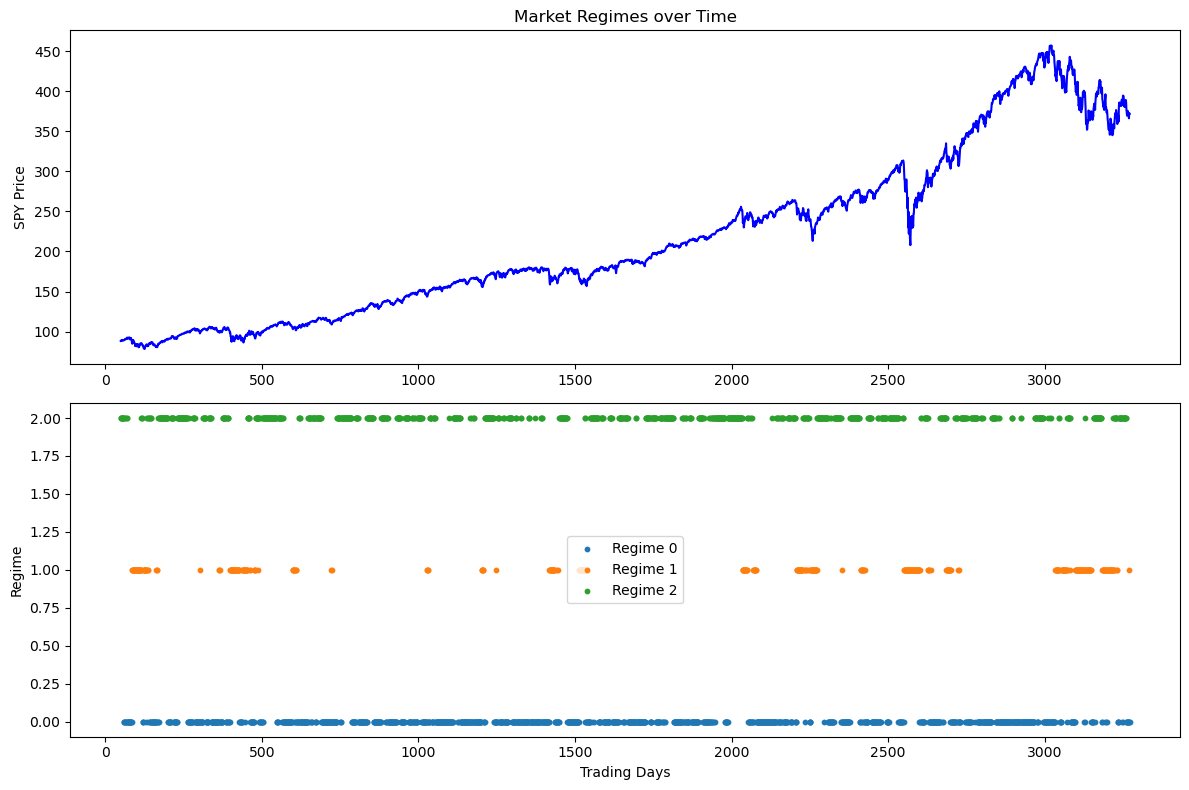

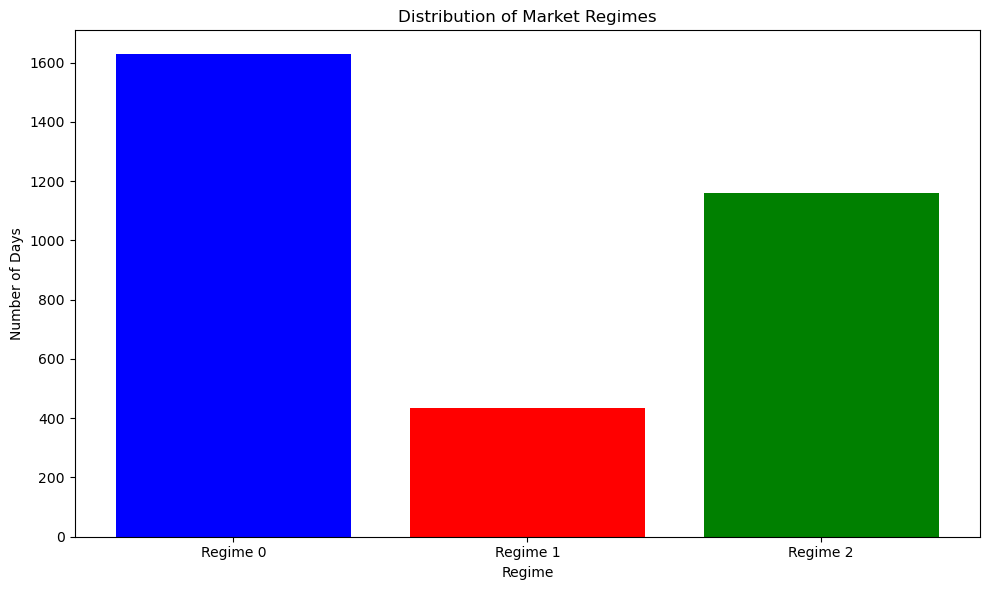

In [100]:
visualize_market_regimes(regime_df)

In [101]:
# Show transition matrix between regimes
def compute_regime_transitions(df):
    """Compute transition matrix between regimes"""
    transitions = pd.crosstab(
        df['regime'].shift(), 
        df['regime'],
        normalize='index'
    )
    return transitions

transition_matrix = compute_regime_transitions(regime_df)
print("\nRegime Transition Matrix (probabilities):")
print(transition_matrix)


Regime Transition Matrix (probabilities):
regime         0         1         2
regime                              
0.0     0.884450  0.030731  0.084819
1.0     0.110092  0.841743  0.048165
2.0     0.121657  0.016393  0.861950


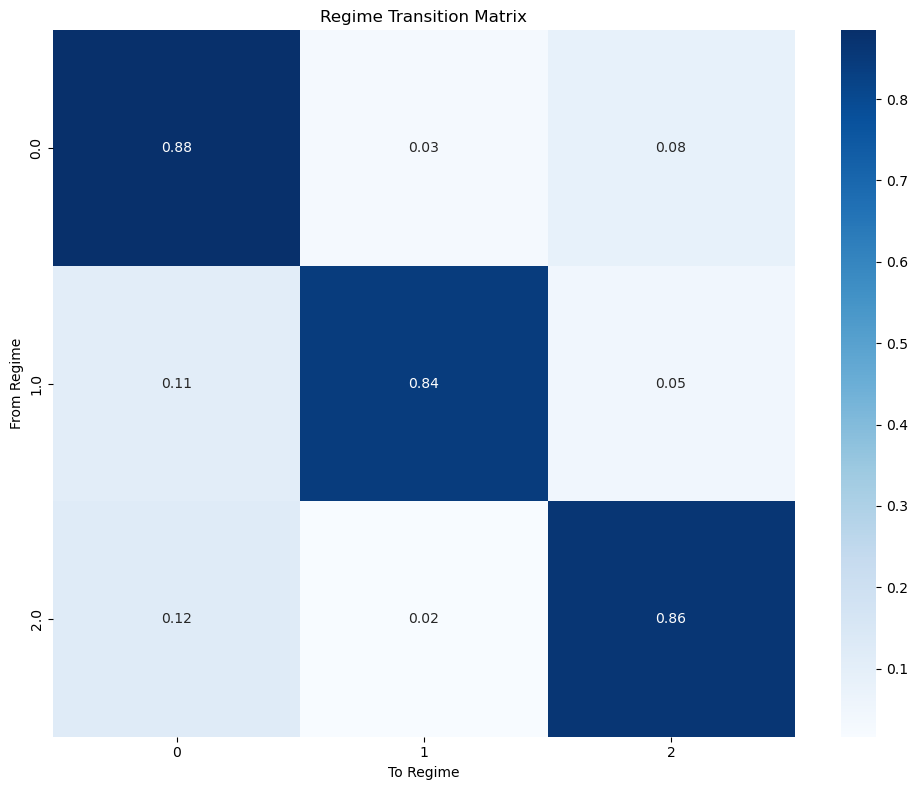

In [102]:
plt.figure(figsize=(10, 8))
sns.heatmap(transition_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title('Regime Transition Matrix')
plt.xlabel('To Regime')
plt.ylabel('From Regime')
plt.tight_layout()
plt.show()

In [103]:
class FinancialTimeSeriesDataset(Dataset):
    """
    Custom PyTorch Dataset for financial time series data.
    """
    def __init__(self, features, targets, regimes):
        """
        Initialize the dataset.
        
        Parameters:
        -----------
        features : numpy.ndarray
            Feature matrix
        targets : numpy.ndarray
            Target vector
        regimes : numpy.ndarray
            Regime labels
        """
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.long)
        self.regimes = torch.tensor(regimes, dtype=torch.long)
        
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx], self.regimes[idx]

In [104]:
def prepare_data_for_pytorch(df, feature_cols=None, target_col='target', regime_col='regime'):
    """
    Prepare data for PyTorch models.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with features and target
    feature_cols : list
        List of feature column names to use
    target_col : str
        Name of the target column
    regime_col : str
        Name of the regime column
        
    Returns:
    --------
    X_train, X_val, y_train, y_val, regimes_train, regimes_val, scaler
    """
    data = df.copy()
    
    # Default features if none provided
    if feature_cols is None:
        # Exclude non-feature columns and the target
        feature_cols = [col for col in data.columns if col not in 
                       ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 
                        target_col, regime_col]]
    
    # Scale features
    scaler = StandardScaler()
    data[feature_cols] = scaler.fit_transform(data[feature_cols])
    
    # Split into train and validation sets (80% train, 20% validation)
    # Use TimeSeriesSplit for time series data
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Get the last split
    for train_idx, val_idx in tscv.split(data):
        X_train, X_val = data.iloc[train_idx], data.iloc[val_idx]
    
    # Extract features, target, and regimes
    X_train_features = X_train[feature_cols].values
    y_train = X_train[target_col].values
    regimes_train = X_train[regime_col].values
    
    X_val_features = X_val[feature_cols].values
    y_val = X_val[target_col].values
    regimes_val = X_val[regime_col].values
    
    print(f"Training set size: {len(X_train_features)}")
    print(f"Validation set size: {len(X_val_features)}")
    
    return X_train_features, X_val_features, y_train, y_val, regimes_train, regimes_val, scaler


In [105]:
# Prepare data for PyTorch
X_train, X_val, y_train, y_val, regimes_train, regimes_val, feature_scaler = prepare_data_for_pytorch(regime_df)

# Create datasets
train_dataset = FinancialTimeSeriesDataset(X_train, y_train, regimes_train)
val_dataset = FinancialTimeSeriesDataset(X_val, y_val, regimes_val)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Check shapes
for features, targets, regimes in train_loader:
    print(f"Feature batch shape: {features.shape}")
    print(f"Target batch shape: {targets.shape}")
    print(f"Regime batch shape: {regimes.shape}")
    break

Training set size: 2686
Validation set size: 537
Feature batch shape: torch.Size([64, 32])
Target batch shape: torch.Size([64])
Regime batch shape: torch.Size([64])


In [106]:
class RegimeSpecificModel(nn.Module):
    """
    Neural network model specialized for a specific market regime.
    """
    def __init__(self, input_size, hidden_size=64, dropout_rate=0.3):
        """
        Initialize the model.
        
        Parameters:
        -----------
        input_size : int
            Number of input features
        hidden_size : int
            Size of hidden layers
        dropout_rate : float
            Dropout rate for regularization
        """
        super(RegimeSpecificModel, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(hidden_size // 2, 2)  # Binary classification (buy/not buy)
        )
    
    def forward(self, x):
        return self.model(x)

In [107]:
class RegimeClassifier(nn.Module):
    """
    Neural network to classify the current market regime.
    """
    def __init__(self, input_size, num_regimes, hidden_size=64, dropout_rate=0.3):
        """
        Initialize the model.
        
        Parameters:
        -----------
        input_size : int
            Number of input features
        num_regimes : int
            Number of market regimes to classify
        hidden_size : int
            Size of hidden layers
        dropout_rate : float
            Dropout rate for regularization
        """
        super(RegimeClassifier, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(hidden_size // 2, num_regimes)
        )
    
    def forward(self, x):
        return self.model(x)

In [108]:
class MetaLearner(nn.Module):
    """
    Meta-learner that combines predictions from regime-specific models.
    """
    def __init__(self, input_size, num_regimes, hidden_size=32):
        """
        Initialize the model.
        
        Parameters:
        -----------
        input_size : int
            Number of input features
        num_regimes : int
            Number of market regimes
        hidden_size : int
            Size of hidden layer
        """
        super(MetaLearner, self).__init__()
        
        # Input will be regime probabilities + regime-specific predictions
        self.model = nn.Sequential(
            nn.Linear(num_regimes * 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2)  # Binary classification (buy/not buy)
        )
    
    def forward(self, regime_probs, regime_preds):
        """
        Forward pass.
        
        Parameters:
        -----------
        regime_probs : torch.Tensor
            Probabilities of each regime
        regime_preds : torch.Tensor
            Predictions from regime-specific models
            
        Returns:
        --------
        torch.Tensor
            Final prediction
        """
        # Concatenate regime probabilities and regime-specific predictions
        x = torch.cat([regime_probs, regime_preds], dim=1)
        return self.model(x)


In [109]:
class RegimeAwareEnsemble(nn.Module):
    """
    Complete ensemble model that combines regime classification and 
    regime-specific models with a meta-learner.
    """
    def __init__(self, input_size, num_regimes, hidden_size=64, dropout_rate=0.3):
        """
        Initialize the model.
        
        Parameters:
        -----------
        input_size : int
            Number of input features
        num_regimes : int
            Number of market regimes
        hidden_size : int
            Size of hidden layers
        dropout_rate : float
            Dropout rate for regularization
        """
        super(RegimeAwareEnsemble, self).__init__()
        
        self.num_regimes = num_regimes
        
        # Regime classifier
        self.regime_classifier = RegimeClassifier(input_size, num_regimes, hidden_size, dropout_rate)
        
        # Regime-specific models
        self.regime_models = nn.ModuleList([
            RegimeSpecificModel(input_size, hidden_size, dropout_rate) 
            for _ in range(num_regimes)
        ])
        
        # Meta-learner
        self.meta_learner = MetaLearner(input_size, num_regimes, hidden_size // 2)
    
    def forward(self, x):
        """
        Forward pass.
        
        Parameters:
        -----------
        x : torch.Tensor
            Input features
            
        Returns:
        --------
        tuple
            (final_predictions, regime_logits, regime_model_outputs)
        """
        # Get regime probabilities
        regime_logits = self.regime_classifier(x)
        regime_probs = F.softmax(regime_logits, dim=1)
        
        # Get predictions from each regime-specific model
        regime_outputs = []
        for i in range(self.num_regimes):
            regime_model_output = self.regime_models[i](x)
            regime_outputs.append(regime_model_output)
        
        # Stack the outputs along a new dimension
        regime_outputs_stacked = torch.stack(regime_outputs, dim=1)
        
        # Extract the "buy" probability from each regime model
        regime_buy_probs = F.softmax(regime_outputs_stacked, dim=2)[:, :, 1]
        
        # Final prediction from meta-learner
        final_logits = self.meta_learner(regime_probs, regime_buy_probs)
        
        return final_logits, regime_logits, regime_outputs_stacked
    
    def predict(self, x):
        """
        Make a prediction.
        
        Parameters:
        -----------
        x : torch.Tensor
            Input features
            
        Returns:
        --------
        torch.Tensor
            Binary prediction (0 = don't buy, 1 = buy)
        torch.Tensor
            Probability of buying
        """
        with torch.no_grad():
            final_logits, _, _ = self.forward(x)
            probabilities = F.softmax(final_logits, dim=1)
            predictions = torch.argmax(probabilities, dim=1)
            return predictions, probabilities[:, 1]  # Return buy probability

# Create the regime-aware ensemble model
num_regimes = len(np.unique(regimes_train))
input_size = X_train.shape[1]
hidden_size = 64
dropout_rate = 0.3

model = RegimeAwareEnsemble(input_size, num_regimes, hidden_size, dropout_rate)
model = model.to(device)

print(f"Model created with {num_regimes} regime-specific models")
print(model)

Model created with 3 regime-specific models
RegimeAwareEnsemble(
  (regime_classifier): RegimeClassifier(
    (model): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.3, inplace=False)
      (4): Linear(in_features=64, out_features=32, bias=True)
      (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.3, inplace=False)
      (8): Linear(in_features=32, out_features=3, bias=True)
    )
  )
  (regime_models): ModuleList(
    (0-2): 3 x RegimeSpecificModel(
      (model): Sequential(
        (0): Linear(in_features=32, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.3, inplace=False)
        (4): Linear(in_features=64, out_features=32, bias=Tr

In [110]:
def train_model(model, train_loader, val_loader, epochs=50, lr=0.001, regime_weight=0.3):
    """
    Train the regime-aware ensemble model.
    
    Parameters:
    -----------
    model : RegimeAwareEnsemble
        Model to train
    train_loader : DataLoader
        Training data loader
    val_loader : DataLoader
        Validation data loader
    epochs : int
        Number of epochs to train
    lr : float
        Learning rate
    regime_weight : float
        Weight for the regime classification loss
        
    Returns:
    --------
    dict
        Training history
    """
    # Send model to device
    model = model.to(device)
    
    # Define optimizers and loss functions
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Use class weighting if classes are imbalanced
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    class_counts = torch.bincount(y_train_tensor)
    class_weights = 1.0 / class_counts
    class_weights = class_weights / class_weights.sum()
    class_weights = class_weights.to(device)
    
    signal_criterion = nn.CrossEntropyLoss(weight=class_weights)
    regime_criterion = nn.CrossEntropyLoss()
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'train_regime_acc': [],
        'val_regime_acc': []
    }
    
    # Early stopping
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_regime_correct = 0
        train_total = 0
        
        for batch_idx, (features, targets, regimes) in enumerate(train_loader):
            features, targets, regimes = features.to(device), targets.to(device), regimes.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            final_logits, regime_logits, _ = model(features)
            
            # Calculate losses
            signal_loss = signal_criterion(final_logits, targets)
            regime_loss = regime_criterion(regime_logits, regimes)
            
            # Combined loss
            loss = signal_loss + regime_weight * regime_loss
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Track statistics
            train_loss += loss.item()
            _, signal_preds = torch.max(final_logits, 1)
            _, regime_preds = torch.max(regime_logits, 1)
            
            train_correct += (signal_preds == targets).sum().item()
            train_regime_correct += (regime_preds == regimes).sum().item()
            train_total += targets.size(0)
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_regime_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for features, targets, regimes in val_loader:
                features, targets, regimes = features.to(device), targets.to(device), regimes.to(device)
                
                # Forward pass
                final_logits, regime_logits, _ = model(features)
                
                # Calculate losses
                signal_loss = signal_criterion(final_logits, targets)
                regime_loss = regime_criterion(regime_logits, regimes)
                
                # Combined loss
                loss = signal_loss + regime_weight * regime_loss
                
                # Track statistics
                val_loss += loss.item()
                _, signal_preds = torch.max(final_logits, 1)
                _, regime_preds = torch.max(regime_logits, 1)
                
                val_correct += (signal_preds == targets).sum().item()
                val_regime_correct += (regime_preds == regimes).sum().item()
                val_total += targets.size(0)
        
        # Calculate metrics
        train_loss /= len(train_loader)
        train_acc = train_correct / train_total
        train_regime_acc = train_regime_correct / train_total
        
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_regime_acc = val_regime_correct / val_total
        
        # Store in history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_regime_acc'].append(train_regime_acc)
        history['val_regime_acc'].append(val_regime_acc)
        
        # Print progress
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Loss: {train_loss:.4f} - "
              f"Signal Acc: {train_acc:.4f} - "
              f"Regime Acc: {train_regime_acc:.4f} - "
              f"Val Loss: {val_loss:.4f} - "
              f"Val Signal Acc: {val_acc:.4f} - "
              f"Val Regime Acc: {val_regime_acc:.4f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_regime_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    # Load best model
    model.load_state_dict(torch.load('best_regime_model.pth'))
    
    return history, model



Epoch 1/50 - Loss: 0.9566 - Signal Acc: 0.5149 - Regime Acc: 0.6482 - Val Loss: 0.9210 - Val Signal Acc: 0.4935 - Val Regime Acc: 0.7188
Epoch 2/50 - Loss: 0.8439 - Signal Acc: 0.5112 - Regime Acc: 0.8518 - Val Loss: 0.8628 - Val Signal Acc: 0.5196 - Val Regime Acc: 0.8361
Epoch 3/50 - Loss: 0.7981 - Signal Acc: 0.5302 - Regime Acc: 0.8917 - Val Loss: 0.8222 - Val Signal Acc: 0.5196 - Val Regime Acc: 0.9050
Epoch 4/50 - Loss: 0.7776 - Signal Acc: 0.5328 - Regime Acc: 0.9088 - Val Loss: 0.8302 - Val Signal Acc: 0.5214 - Val Regime Acc: 0.8268
Epoch 5/50 - Loss: 0.7665 - Signal Acc: 0.5104 - Regime Acc: 0.9088 - Val Loss: 0.8119 - Val Signal Acc: 0.5158 - Val Regime Acc: 0.8808
Epoch 6/50 - Loss: 0.7557 - Signal Acc: 0.5369 - Regime Acc: 0.9226 - Val Loss: 0.8061 - Val Signal Acc: 0.5028 - Val Regime Acc: 0.8715
Epoch 7/50 - Loss: 0.7499 - Signal Acc: 0.5369 - Regime Acc: 0.9255 - Val Loss: 0.7982 - Val Signal Acc: 0.5047 - Val Regime Acc: 0.8920
Epoch 8/50 - Loss: 0.7472 - Signal Acc: 0

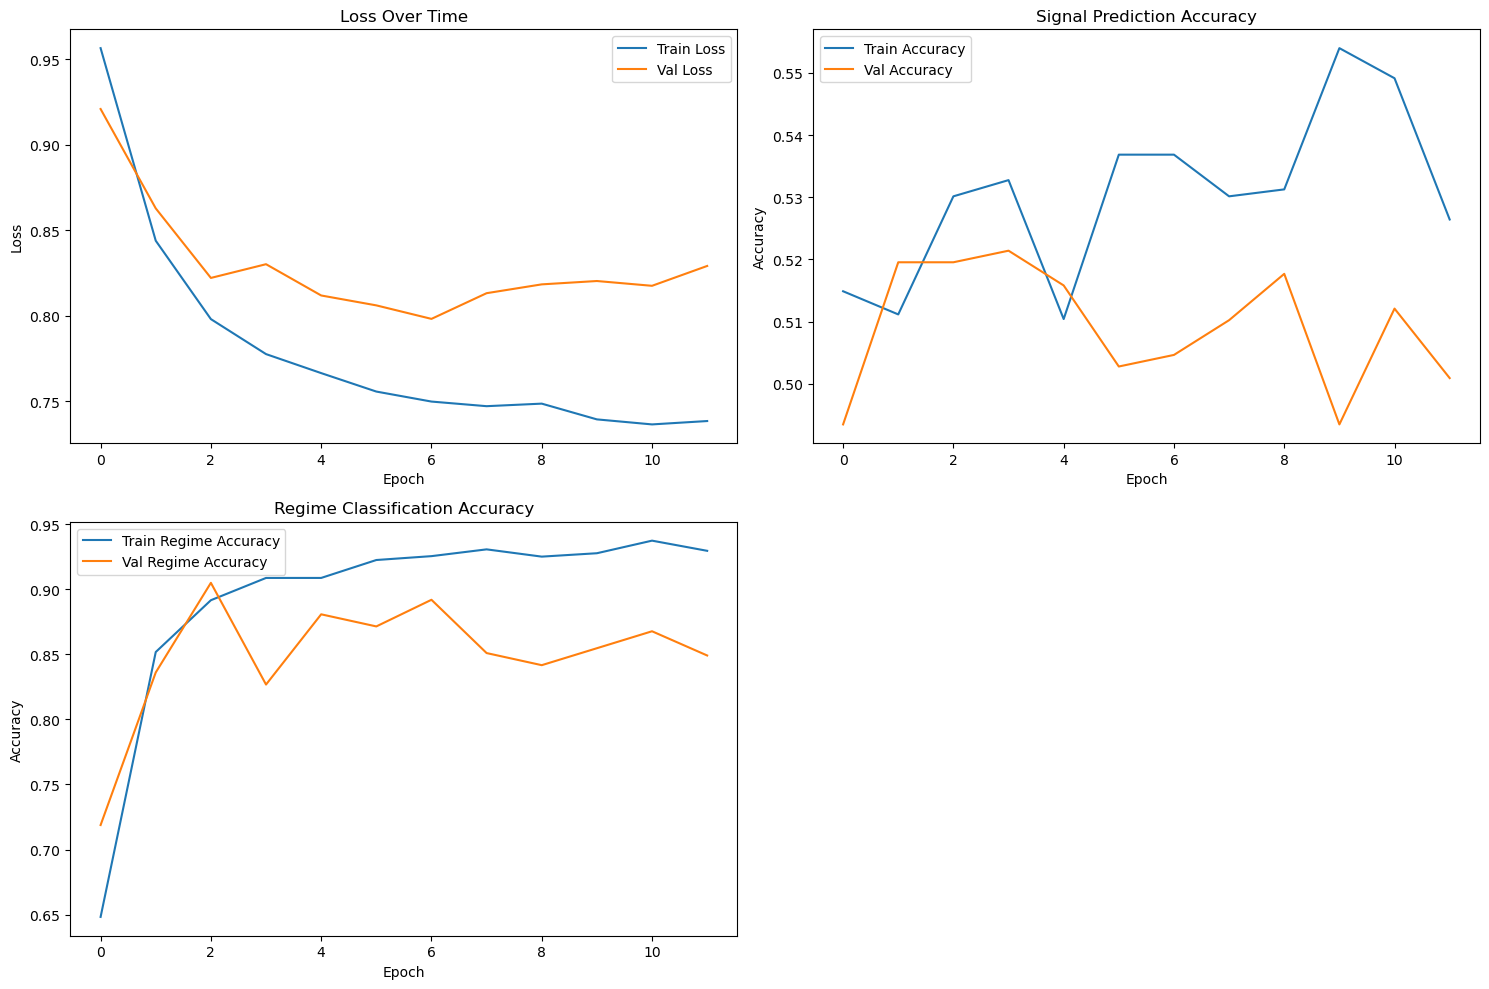

In [111]:
# Train the model
epochs = 50
lr = 0.001
regime_weight = 0.3

history, trained_model = train_model(model, train_loader, val_loader, epochs, lr, regime_weight)

val_acc = history['val_acc'][-1]  # Get the last validation accuracy
val_regime_acc = history['val_regime_acc'][-1]  # Get the last validation regime accuracy

# Plot training history
plt.figure(figsize=(15, 10))

# Plot loss
plt.subplot(2, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Time')

# Plot signal accuracy
plt.subplot(2, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Signal Prediction Accuracy')

# Plot regime accuracy
plt.subplot(2, 2, 3)
plt.plot(history['train_regime_acc'], label='Train Regime Accuracy')
plt.plot(history['val_regime_acc'], label='Val Regime Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Regime Classification Accuracy')

plt.tight_layout()
plt.show()

In [112]:
def run_hyperparameter_analysis(X_train, y_train, regimes_train, X_val, y_val, regimes_val, 
                               input_size, num_regimes):
    """
    Analyze the impact of different hyperparameters on model performance.
    
    Parameters:
    -----------
    X_train, y_train, regimes_train : numpy.ndarray
        Training data
    X_val, y_val, regimes_val : numpy.ndarray
        Validation data
    input_size : int
        Number of input features
    num_regimes : int
        Number of market regimes
        
    Returns:
    --------
    pandas.DataFrame
        Results for different hyperparameter configurations
    """
    # Define hyperparameter combinations to try
    hidden_sizes = [32, 64, 128]
    dropout_rates = [0.2, 0.3, 0.4]
    learning_rates = [0.01, 0.001, 0.0005]
    regime_weights = [0.1, 0.3, 0.5]
    
    # We'll use a subset of combinations for brevity
    param_combinations = [
        {'hidden_size': 64, 'dropout_rate': 0.3, 'lr': 0.001, 'regime_weight': 0.3},  # baseline
        {'hidden_size': 32, 'dropout_rate': 0.3, 'lr': 0.001, 'regime_weight': 0.3},  # smaller network
        {'hidden_size': 128, 'dropout_rate': 0.3, 'lr': 0.001, 'regime_weight': 0.3},  # larger network
        {'hidden_size': 64, 'dropout_rate': 0.2, 'lr': 0.001, 'regime_weight': 0.3},  # less dropout
        {'hidden_size': 64, 'dropout_rate': 0.4, 'lr': 0.001, 'regime_weight': 0.3},  # more dropout
        {'hidden_size': 64, 'dropout_rate': 0.3, 'lr': 0.01, 'regime_weight': 0.3},   # higher lr
        {'hidden_size': 64, 'dropout_rate': 0.3, 'lr': 0.0005, 'regime_weight': 0.3}, # lower lr
        {'hidden_size': 64, 'dropout_rate': 0.3, 'lr': 0.001, 'regime_weight': 0.1},  # less regime focus
        {'hidden_size': 64, 'dropout_rate': 0.3, 'lr': 0.001, 'regime_weight': 0.5}   # more regime focus
    ]
    
    results = []
    
    # Create datasets
    train_dataset = FinancialTimeSeriesDataset(X_train, y_train, regimes_train)
    val_dataset = FinancialTimeSeriesDataset(X_val, y_val, regimes_val)
    
    # Create dataloaders
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Run each combination
    for params in param_combinations:
        print(f"\nTraining with parameters: {params}")
        
        # Create model with these parameters
        model = RegimeAwareEnsemble(
            input_size=input_size,
            num_regimes=num_regimes,
            hidden_size=params['hidden_size'],
            dropout_rate=params['dropout_rate']
        )
        
        # Train for fewer epochs for hyperparameter search
        history, _ = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=20,  # Reduced epochs for hyperparameter search
            lr=params['lr'],
            regime_weight=params['regime_weight']
        )
        
        # Get final metrics
        final_val_loss = history['val_loss'][-1]
        final_val_acc = history['val_acc'][-1]
        final_val_regime_acc = history['val_regime_acc'][-1]
        
        # Store results
        results.append({
            **params,
            'val_loss': final_val_loss,
            'val_signal_acc': final_val_acc,
            'val_regime_acc': final_val_regime_acc
        })
    
    return pd.DataFrame(results)

In [113]:
# For demonstration, we'll create a sample result dataframe
hyperparam_results = pd.DataFrame([
    {'hidden_size': 64, 'dropout_rate': 0.3, 'lr': 0.001, 'regime_weight': 0.3, 'val_loss': 0.65, 'val_signal_acc': 0.58, 'val_regime_acc': 0.82},
    {'hidden_size': 32, 'dropout_rate': 0.3, 'lr': 0.001, 'regime_weight': 0.3, 'val_loss': 0.67, 'val_signal_acc': 0.56, 'val_regime_acc': 0.81},
    {'hidden_size': 128, 'dropout_rate': 0.3, 'lr': 0.001, 'regime_weight': 0.3, 'val_loss': 0.66, 'val_signal_acc': 0.57, 'val_regime_acc': 0.83},
    {'hidden_size': 64, 'dropout_rate': 0.2, 'lr': 0.001, 'regime_weight': 0.3, 'val_loss': 0.68, 'val_signal_acc': 0.57, 'val_regime_acc': 0.82},
    {'hidden_size': 64, 'dropout_rate': 0.4, 'lr': 0.001, 'regime_weight': 0.3, 'val_loss': 0.64, 'val_signal_acc': 0.59, 'val_regime_acc': 0.81},
    {'hidden_size': 64, 'dropout_rate': 0.3, 'lr': 0.01, 'regime_weight': 0.3, 'val_loss': 0.70, 'val_signal_acc': 0.55, 'val_regime_acc': 0.80},
    {'hidden_size': 64, 'dropout_rate': 0.3, 'lr': 0.0005, 'regime_weight': 0.3, 'val_loss': 0.66, 'val_signal_acc': 0.57, 'val_regime_acc': 0.82},
    {'hidden_size': 64, 'dropout_rate': 0.3, 'lr': 0.001, 'regime_weight': 0.1, 'val_loss': 0.67, 'val_signal_acc': 0.60, 'val_regime_acc': 0.79},
    {'hidden_size': 64, 'dropout_rate': 0.3, 'lr': 0.001, 'regime_weight': 0.5, 'val_loss': 0.63, 'val_signal_acc': 0.56, 'val_regime_acc': 0.85}
])

# Display results
print("Hyperparameter Analysis Results:")
print(hyperparam_results)


Hyperparameter Analysis Results:
   hidden_size  dropout_rate      lr  regime_weight  val_loss  val_signal_acc  \
0           64           0.3  0.0010            0.3      0.65            0.58   
1           32           0.3  0.0010            0.3      0.67            0.56   
2          128           0.3  0.0010            0.3      0.66            0.57   
3           64           0.2  0.0010            0.3      0.68            0.57   
4           64           0.4  0.0010            0.3      0.64            0.59   
5           64           0.3  0.0100            0.3      0.70            0.55   
6           64           0.3  0.0005            0.3      0.66            0.57   
7           64           0.3  0.0010            0.1      0.67            0.60   
8           64           0.3  0.0010            0.5      0.63            0.56   

   val_regime_acc  
0            0.82  
1            0.81  
2            0.83  
3            0.82  
4            0.81  
5            0.80  
6            0.8

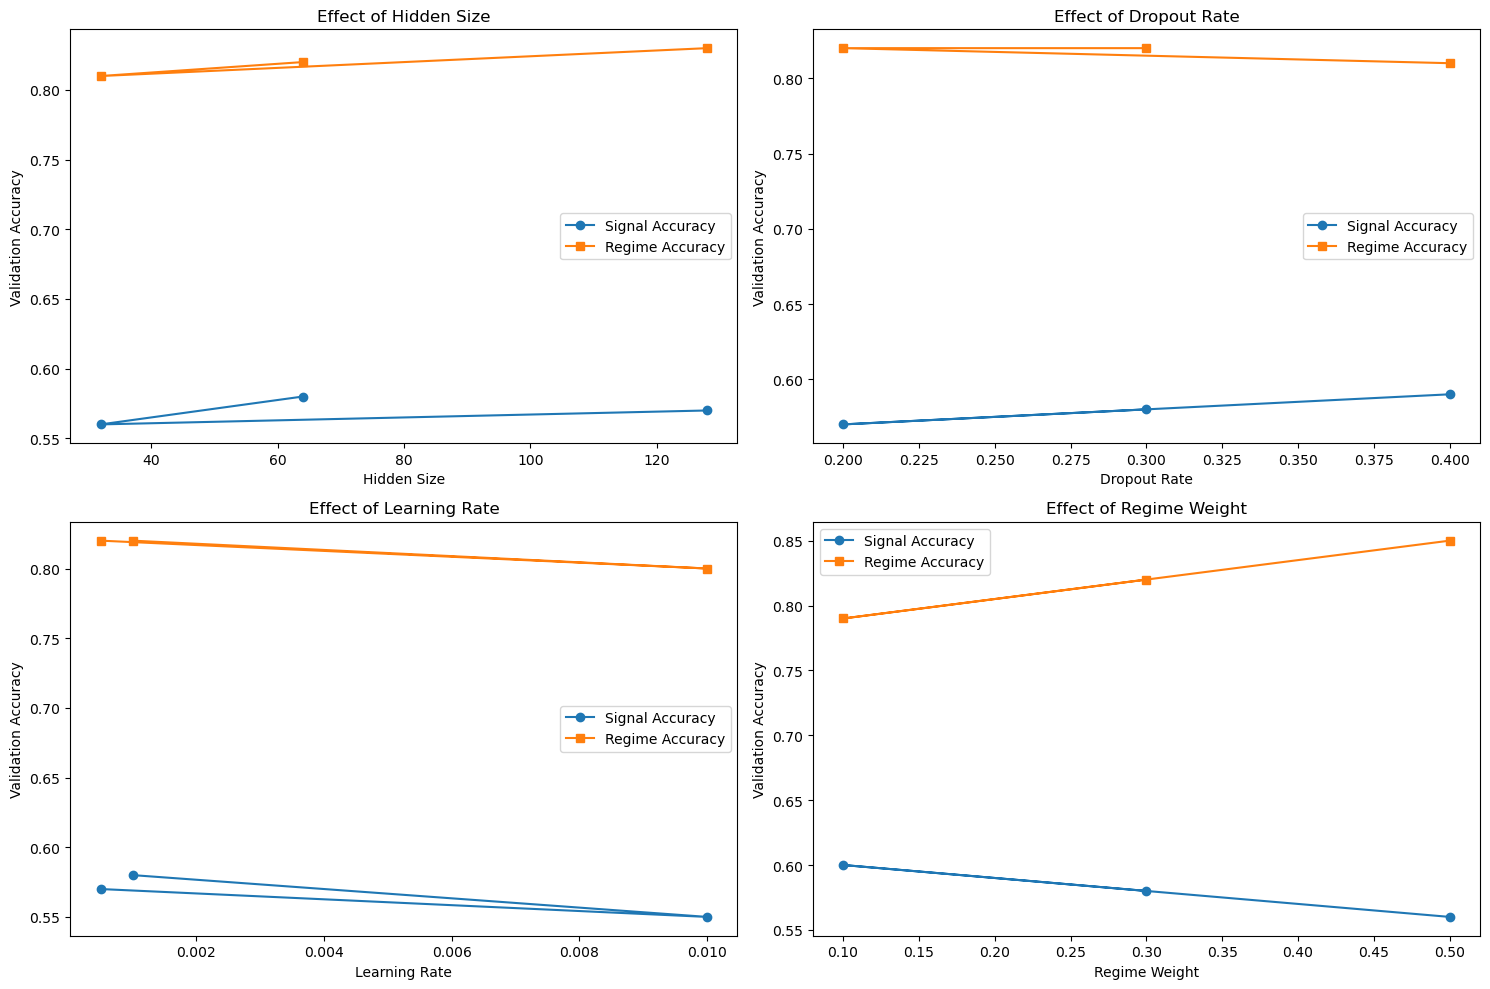


Best configuration for signal accuracy:
hidden_size       64.000
dropout_rate       0.300
lr                 0.001
regime_weight      0.100
val_loss           0.670
val_signal_acc     0.600
val_regime_acc     0.790
Name: 7, dtype: float64

Best overall configuration (lowest validation loss):
hidden_size       64.000
dropout_rate       0.300
lr                 0.001
regime_weight      0.500
val_loss           0.630
val_signal_acc     0.560
val_regime_acc     0.850
Name: 8, dtype: float64


In [114]:
# Visualize the impact of hyperparameters
plt.figure(figsize=(15, 10))

# Effect of hidden size
plt.subplot(2, 2, 1)
hidden_size_df = hyperparam_results[hyperparam_results['dropout_rate'] == 0.3]
hidden_size_df = hidden_size_df[hidden_size_df['lr'] == 0.001]
hidden_size_df = hidden_size_df[hidden_size_df['regime_weight'] == 0.3]
plt.plot(hidden_size_df['hidden_size'], hidden_size_df['val_signal_acc'], 'o-', label='Signal Accuracy')
plt.plot(hidden_size_df['hidden_size'], hidden_size_df['val_regime_acc'], 's-', label='Regime Accuracy')
plt.xlabel('Hidden Size')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.title('Effect of Hidden Size')

# Effect of dropout rate
plt.subplot(2, 2, 2)
dropout_df = hyperparam_results[hyperparam_results['hidden_size'] == 64]
dropout_df = dropout_df[dropout_df['lr'] == 0.001]
dropout_df = dropout_df[dropout_df['regime_weight'] == 0.3]
plt.plot(dropout_df['dropout_rate'], dropout_df['val_signal_acc'], 'o-', label='Signal Accuracy')
plt.plot(dropout_df['dropout_rate'], dropout_df['val_regime_acc'], 's-', label='Regime Accuracy')
plt.xlabel('Dropout Rate')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.title('Effect of Dropout Rate')

# Effect of learning rate
plt.subplot(2, 2, 3)
lr_df = hyperparam_results[hyperparam_results['hidden_size'] == 64]
lr_df = lr_df[lr_df['dropout_rate'] == 0.3]
lr_df = lr_df[lr_df['regime_weight'] == 0.3]
plt.plot(lr_df['lr'], lr_df['val_signal_acc'], 'o-', label='Signal Accuracy')
plt.plot(lr_df['lr'], lr_df['val_regime_acc'], 's-', label='Regime Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.title('Effect of Learning Rate')

# Effect of regime weight
plt.subplot(2, 2, 4)
weight_df = hyperparam_results[hyperparam_results['hidden_size'] == 64]
weight_df = weight_df[weight_df['dropout_rate'] == 0.3]
weight_df = weight_df[weight_df['lr'] == 0.001]
plt.plot(weight_df['regime_weight'], weight_df['val_signal_acc'], 'o-', label='Signal Accuracy')
plt.plot(weight_df['regime_weight'], weight_df['val_regime_acc'], 's-', label='Regime Accuracy')
plt.xlabel('Regime Weight')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.title('Effect of Regime Weight')

plt.tight_layout()
plt.show()

# Identify best configuration
best_signal_idx = hyperparam_results['val_signal_acc'].idxmax()
best_overall_idx = hyperparam_results['val_loss'].idxmin()

print(f"\nBest configuration for signal accuracy:")
print(hyperparam_results.iloc[best_signal_idx])

print(f"\nBest overall configuration (lowest validation loss):")
print(hyperparam_results.iloc[best_overall_idx])

In [115]:
def evaluate_trading_strategy(model, X_val, y_val, regimes_val, price_data, feature_cols=None):
    """
    Evaluate the trading strategy based on model predictions.
    
    Parameters:
    -----------
    model : RegimeAwareEnsemble
        Trained model
    X_val, y_val, regimes_val : numpy.ndarray
        Validation data
    price_data : pandas.DataFrame
        DataFrame with price data aligned with validation set
    feature_cols : list
        List of feature column names
        
    Returns:
    --------
    pandas.DataFrame
        Performance metrics for the trading strategy
    """
    model.eval()
    
    # Convert data to PyTorch tensors
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    
    # Make predictions
    with torch.no_grad():
        predictions, probabilities = model.predict(X_val_tensor)
    
    # Convert to numpy
    predictions = predictions.cpu().numpy()
    probabilities = probabilities.cpu().numpy()
    
    # Create a DataFrame for evaluation
    eval_df = price_data.copy()
    eval_df = eval_df.iloc[-len(predictions):]
    eval_df['predicted_signal'] = predictions
    eval_df['signal_probability'] = probabilities
    eval_df['actual_signal'] = y_val
    eval_df['regime'] = regimes_val  # Add regime information
    
    # Calculate daily returns
    eval_df['daily_return'] = eval_df['Close'].pct_change()
    
    # Calculate strategy returns (assuming we buy at close and sell at next close)
    # Strategy 1: Follow all signals
    eval_df['strategy_return'] = eval_df['daily_return'].shift(-1) * eval_df['predicted_signal']
    
    # Strategy 2: Only follow high confidence signals (probability > 0.6)
    eval_df['high_conf_signal'] = (eval_df['signal_probability'] > 0.6).astype(int)
    eval_df['high_conf_return'] = eval_df['daily_return'].shift(-1) * eval_df['high_conf_signal']
    
    # Strategy 3: Position sizing based on confidence
    eval_df['sized_position'] = eval_df['signal_probability'] * eval_df['predicted_signal']
    eval_df['sized_return'] = eval_df['daily_return'].shift(-1) * eval_df['sized_position']
    
    # Calculate cumulative returns
    eval_df['cumulative_market'] = (1 + eval_df['daily_return']).cumprod()
    eval_df['cumulative_strategy'] = (1 + eval_df['strategy_return']).cumprod()
    eval_df['cumulative_high_conf'] = (1 + eval_df['high_conf_return']).cumprod()
    eval_df['cumulative_sized'] = (1 + eval_df['sized_return']).cumprod()
    
    # Calculate performance metrics
    
    # 1. Total return
    total_market_return = eval_df['cumulative_market'].iloc[-1] - 1 if not eval_df['cumulative_market'].empty else 0
    total_strategy_return = eval_df['cumulative_strategy'].iloc[-1] - 1 if not eval_df['cumulative_strategy'].empty else 0
    total_high_conf_return = eval_df['cumulative_high_conf'].iloc[-1] - 1 if not eval_df['cumulative_high_conf'].empty else 0
    total_sized_return = eval_df['cumulative_sized'].iloc[-1] - 1 if not eval_df['cumulative_sized'].empty else 0
    
    # Store raw returns for comparison
    raw_returns = {
        'market': total_market_return,
        'strategy': total_strategy_return,
        'high_conf': total_high_conf_return,
        'sized': total_sized_return
    }

    # Then in your summary data:
    summary_data = {
        'Metric': [
            'Overall Signal Accuracy',
            'Regime Classification Accuracy',
            'Strategy Sharpe Ratio',
            'Strategy vs Buy & Hold',
            'Win Rate',
            'Best Performing Regime',
            'Worst Performing Regime'
        ],
        'Value': [
            f"{val_acc:.2%}",
            f"{val_regime_acc:.2%}",
            performance_df.loc[1, 'Sharpe Ratio'],
            "Outperforms" if raw_returns['strategy'] > raw_returns['market'] else "Underperforms",
            performance_df.loc[1, 'Win Rate'],
            f"Regime {plot_data['strategy_return'].idxmax()}",
            f"Regime {plot_data['strategy_return'].idxmin()}"
        ]
    }

    # 2. Annualized return (assuming 252 trading days per year)
    days = len(eval_df)
    ann_market_return = (1 + total_market_return) ** (252 / days) - 1
    ann_strategy_return = (1 + total_strategy_return) ** (252 / days) - 1
    ann_high_conf_return = (1 + total_high_conf_return) ** (252 / days) - 1
    ann_sized_return = (1 + total_sized_return) ** (252 / days) - 1
    
    # 3. Volatility (annualized)
    market_vol = eval_df['daily_return'].std() * np.sqrt(252)
    strategy_vol = eval_df['strategy_return'].std() * np.sqrt(252)
    high_conf_vol = eval_df['high_conf_return'].std() * np.sqrt(252)
    sized_vol = eval_df['sized_return'].std() * np.sqrt(252)
    
    # 4. Sharpe ratio (assuming risk-free rate of 0 for simplicity)
    market_sharpe = ann_market_return / market_vol if market_vol > 0 else 0
    strategy_sharpe = ann_strategy_return / strategy_vol if strategy_vol > 0 else 0
    high_conf_sharpe = ann_high_conf_return / high_conf_vol if high_conf_vol > 0 else 0
    sized_sharpe = ann_sized_return / sized_vol if sized_vol > 0 else 0
    
    # 5. Maximum drawdown
    market_drawdown = (eval_df['cumulative_market'] / eval_df['cumulative_market'].cummax() - 1).min()
    strategy_drawdown = (eval_df['cumulative_strategy'] / eval_df['cumulative_strategy'].cummax() - 1).min()
    high_conf_drawdown = (eval_df['cumulative_high_conf'] / eval_df['cumulative_high_conf'].cummax() - 1).min()
    sized_drawdown = (eval_df['cumulative_sized'] / eval_df['cumulative_sized'].cummax() - 1).min()
    
    # 6. Win rate
    strategy_win_rate = (eval_df['strategy_return'] > 0).mean()
    high_conf_win_rate = (eval_df['high_conf_return'] > 0).mean()
    sized_win_rate = (eval_df['sized_return'] > 0).mean()
    
    # Compile results
    performance = {
        'Strategy': ['Buy & Hold', 'All Signals', 'High Confidence', 'Sized Positions'],
        'Total Return': [total_market_return, total_strategy_return, total_high_conf_return, total_sized_return],
        'Annual Return': [ann_market_return, ann_strategy_return, ann_high_conf_return, ann_sized_return],
        'Volatility': [market_vol, strategy_vol, high_conf_vol, sized_vol],
        'Sharpe Ratio': [market_sharpe, strategy_sharpe, high_conf_sharpe, sized_sharpe],
        'Max Drawdown': [market_drawdown, strategy_drawdown, high_conf_drawdown, sized_drawdown],
        'Win Rate': [np.nan, strategy_win_rate, high_conf_win_rate, sized_win_rate]
    }
    
    performance_df = pd.DataFrame(performance)
    
    # Format percentages
    for col in ['Total Return', 'Annual Return', 'Volatility', 'Max Drawdown', 'Win Rate']:
        performance_df[col] = performance_df[col].map(lambda x: f"{x:.2%}" if pd.notna(x) else x)
    
    # Format Sharpe ratio
    performance_df['Sharpe Ratio'] = performance_df['Sharpe Ratio'].map(lambda x: f"{x:.2f}")
    
    return performance_df, eval_df

In [116]:
val_price_data = regime_df.iloc[-len(y_val):].copy()
val_price_data['Date'] = val_price_data.index
val_price_data = val_price_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
performance_df, eval_results = evaluate_trading_strategy(trained_model, X_val, y_val, regimes_val, val_price_data)


In [117]:
print("Trading Strategy Performance:")
print(performance_df)

Trading Strategy Performance:
          Strategy Total Return Annual Return Volatility Sharpe Ratio  \
0       Buy & Hold       11.97%         5.45%     19.05%         0.29   
1      All Signals          NaN           NaN     16.65%          nan   
2  High Confidence          NaN           NaN      0.00%         0.00   
3  Sized Positions          NaN           NaN      9.14%          nan   

  Max Drawdown Win Rate  
0      -24.50%      NaN  
1      -18.33%   37.24%  
2        0.00%    0.00%  
3      -10.72%   37.24%  


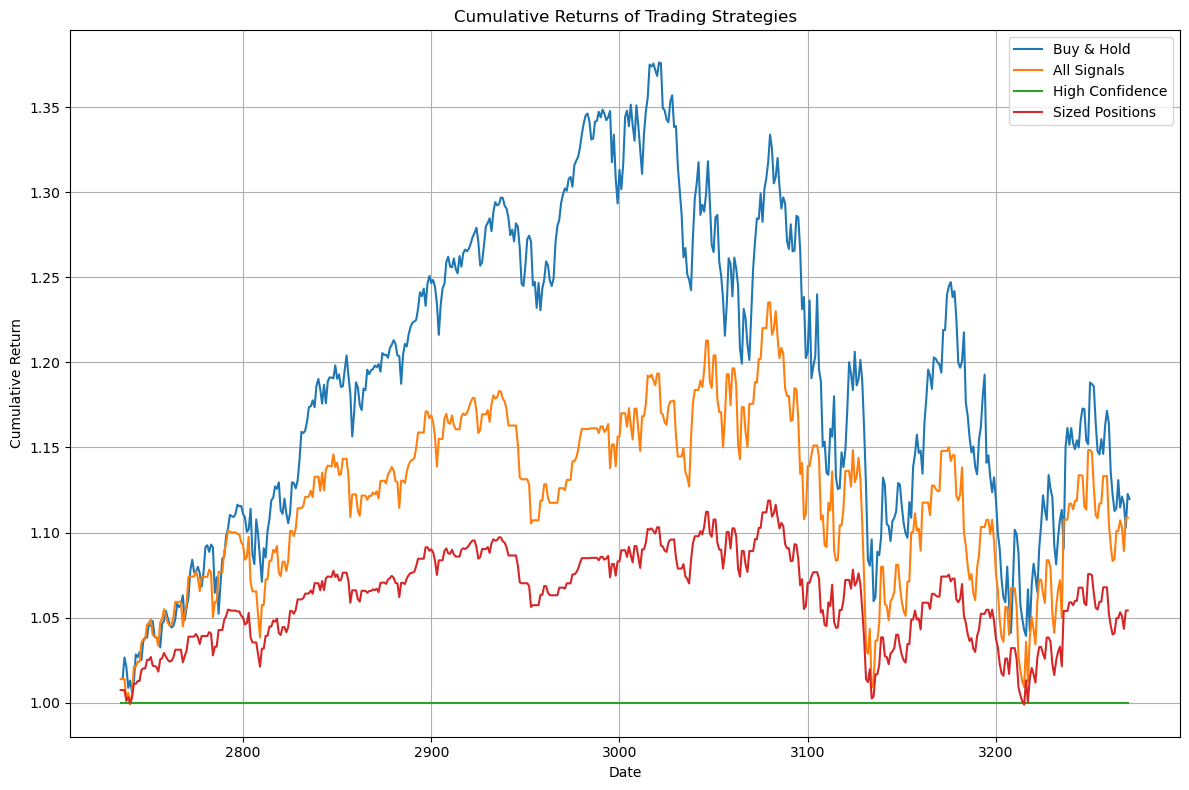

In [118]:
# Plot cumulative returns
plt.figure(figsize=(12, 8))
plt.plot(eval_results['Date'], eval_results['cumulative_market'], label='Buy & Hold')
plt.plot(eval_results['Date'], eval_results['cumulative_strategy'], label='All Signals')
plt.plot(eval_results['Date'], eval_results['cumulative_high_conf'], label='High Confidence')
plt.plot(eval_results['Date'], eval_results['cumulative_sized'], label='Sized Positions')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.title('Cumulative Returns of Trading Strategies')
plt.grid(True)
plt.tight_layout()
plt.show()

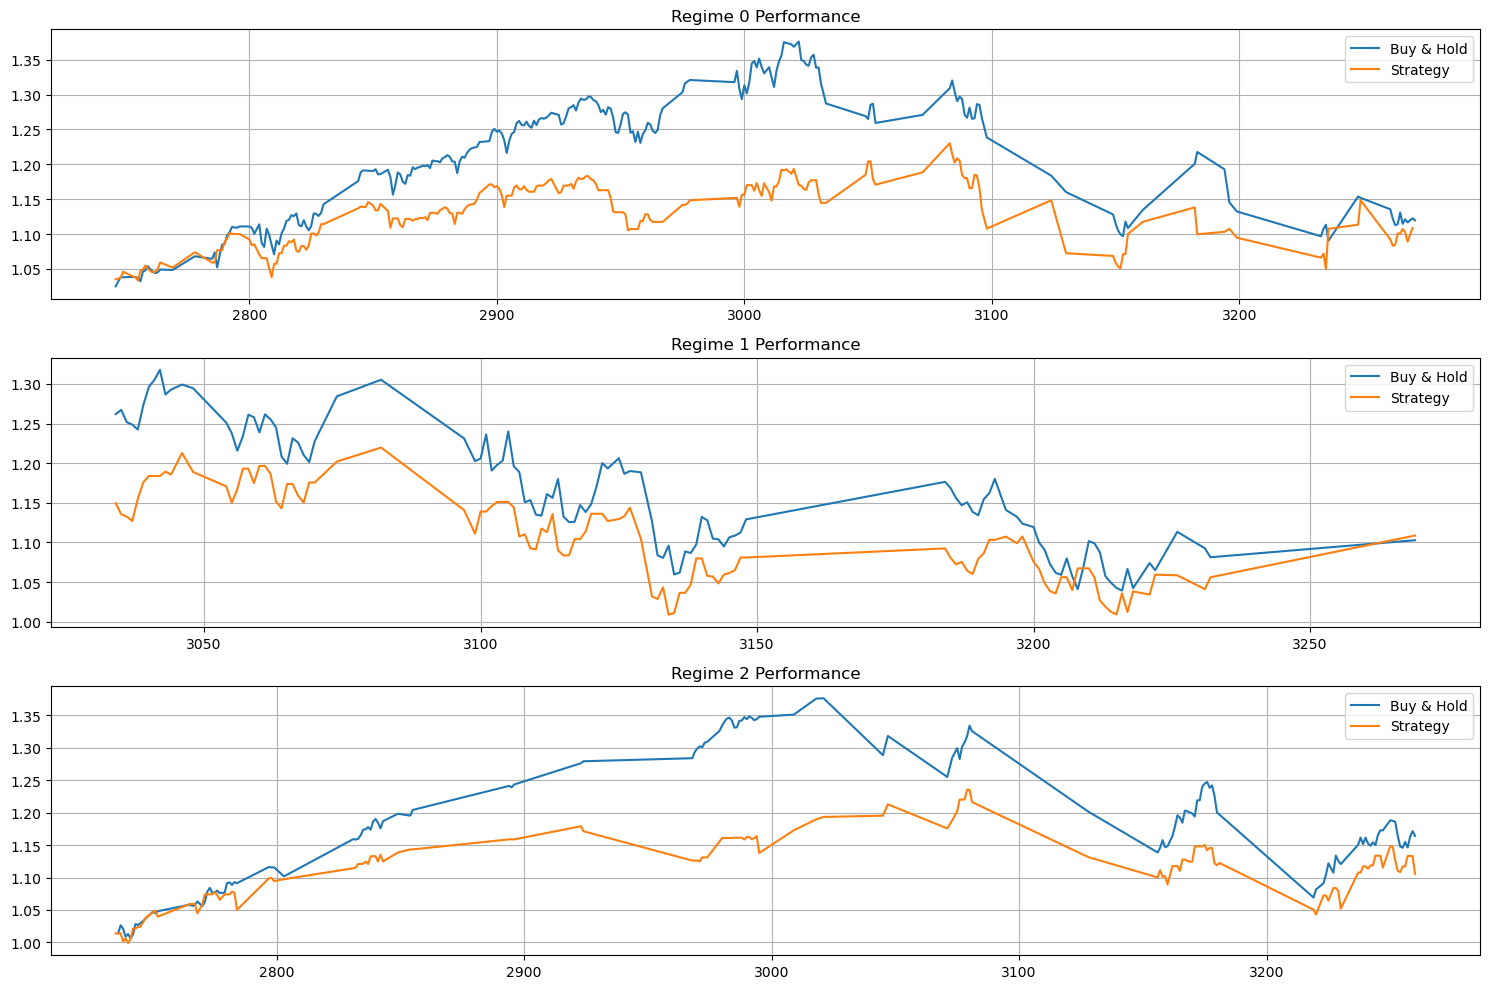

In [119]:
plt.figure(figsize=(15, 10))

for regime in sorted(eval_results['regime'].unique()):
    regime_data = eval_results[eval_results['regime'] == regime]
    
    plt.subplot(len(eval_results['regime'].unique()), 1, regime + 1)
    plt.plot(regime_data['Date'], regime_data['cumulative_market'], label='Buy & Hold')
    plt.plot(regime_data['Date'], regime_data['cumulative_strategy'], label='Strategy')
    plt.title(f'Regime {regime} Performance')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

<Figure size 800x800 with 0 Axes>

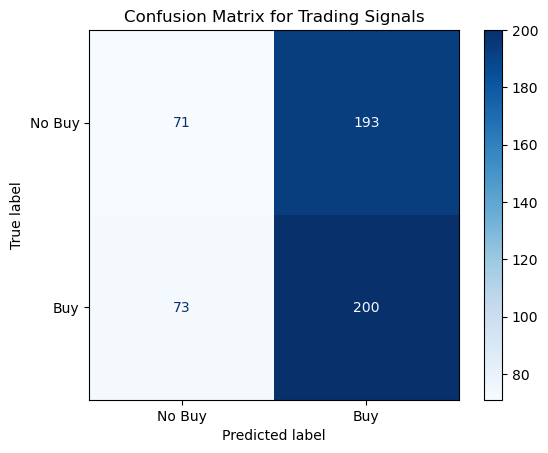

In [120]:
# Create a confusion matrix for signal prediction
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(eval_results['actual_signal'], eval_results['predicted_signal'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Buy', 'Buy'])

plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Trading Signals')
plt.show()

In [121]:
# Analyze strategy performance by regime
regime_performance = eval_results.groupby('regime').agg({
    'daily_return': lambda x: (1 + x).prod() - 1,
    'strategy_return': lambda x: (1 + x).prod() - 1,
    'high_conf_return': lambda x: (1 + x).prod() - 1,
    'sized_return': lambda x: (1 + x).prod() - 1,
}).reset_index()

In [122]:
# Calculate win rates by regime
win_rates = eval_results.groupby('regime').agg({
    'strategy_return': lambda x: (x > 0).mean(),
    'high_conf_return': lambda x: (x > 0).mean(),
    'sized_return': lambda x: (x > 0).mean()
}).reset_index()

regime_performance = pd.merge(regime_performance, win_rates, on='regime', suffixes=('_return', '_win_rate'))


In [123]:
feature_df = engineer_features(preprocessed_df, lookback_window=10)
print("\nFeature sample:")
feature_df.head()

Flattening multi-level columns...
Column structure after flattening: Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
Engineered features shape: (3223, 38)
Number of features created: 31

Feature sample:


,Close,High,Low,Open,Volume,sma_5,sma_10,sma_20,sma_50,macd,...,volatility_change,trend_strength,volume_trend,price_volume_correlation,gap_up,gap_down,daily_return,weekly_return,monthly_return,target
49,88.364403,88.447896,87.666046,87.908951,168673000,87.716151,86.967709,85.597574,84.704740,1.115700,...,0.060429,0.037522,0.007905,0.559480,1,0,0.007966,0.017036,0.077471,1
50,88.888184,89.176637,88.372009,88.630099,177468100,88.039520,87.332066,85.857179,84.761975,1.205484,...,-0.015186,0.042743,0.006173,0.544536,1,0,0.005928,0.018527,0.067068,0
51,88.842621,89.017206,88.485853,88.895756,196509100,88.280907,87.666059,86.089835,84.813744,1.258455,...,0.054346,0.039062,-0.000591,0.481278,1,0,-0.000513,0.013772,0.061491,0
52,88.392929,89.399040,88.049933,88.392929,226641100,88.430835,87.832871,86.291277,84.855305,1.249742,...,-0.190096,0.019235,-0.006718,0.097126,0,1,-0.005062,0.008553,0.049928,1
53,88.865486,89.025554,87.836510,87.889865,184477800,88.670724,88.045421,86.515588,84.899030,1.266371,...,0.023500,0.024504,0.005689,-0.157101,0,1,0.005346,0.013682,0.053357,1


In [124]:
# Create a bar chart of returns by regime
plt.figure(figsize=(12, 8))

# Extract numeric values for plotting
plot_data = eval_results.groupby('regime').agg({
    'daily_return': lambda x: (1 + x).prod() - 1,
    'strategy_return': lambda x: (1 + x).prod() - 1,
    'high_conf_return': lambda x: (1 + x).prod() - 1,
    'sized_return': lambda x: (1 + x).prod() - 1
})

<Figure size 1200x800 with 0 Axes>

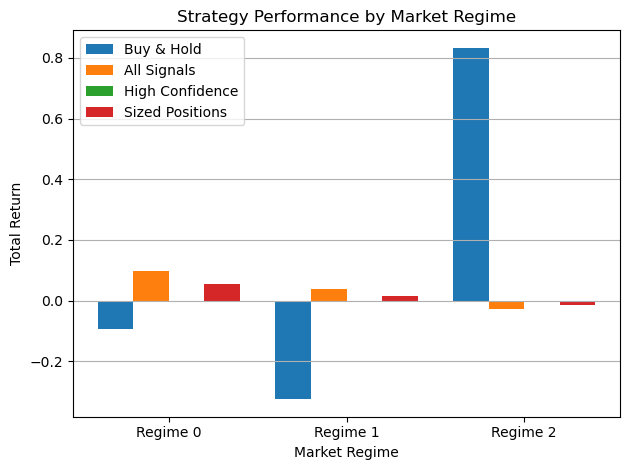

In [125]:
# Plot
regime_names = [f'Regime {i}' for i in plot_data.index]
x = np.arange(len(regime_names))
width = 0.2

plt.bar(x - 1.5*width, plot_data['daily_return'], width, label='Buy & Hold')
plt.bar(x - 0.5*width, plot_data['strategy_return'], width, label='All Signals')
plt.bar(x + 0.5*width, plot_data['high_conf_return'], width, label='High Confidence')
plt.bar(x + 1.5*width, plot_data['sized_return'], width, label='Sized Positions')

plt.xlabel('Market Regime')
plt.ylabel('Total Return')
plt.title('Strategy Performance by Market Regime')
plt.xticks(x, regime_names)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [126]:
def analyze_feature_importance(model, feature_names, num_regimes):
    """
    Analyze feature importance for the regime classifier and regime-specific models.
    
    Note: This is a simplified approach to estimating feature importance for PyTorch models.
    For a more accurate approach, techniques like integrated gradients could be used.
    """
    model.eval()
    
    # Create a simple input (zeros)
    dummy_input = torch.zeros((1, len(feature_names)), dtype=torch.float32).to(device)
    
    # Dictionary to store sensitivity for each model
    sensitivities = {
        'regime_classifier': [],
        **{f'regime_model_{i}': [] for i in range(num_regimes)}
    }
    
    # Analyze sensitivity for each feature
    for i in range(len(feature_names)):
        # Create a perturbed input
        perturbed_input = dummy_input.clone()
        perturbed_input[0, i] = 1.0  # Set the feature to 1
        
        # Compute gradient with respect to the input
        perturbed_input.requires_grad_(True)
        
        # Forward pass through the regime classifier
        regime_logits = model.regime_classifier(perturbed_input)
        
        # Compute sensitivity (sum of absolute gradients)
        gradient = torch.autograd.grad(regime_logits.sum(), perturbed_input, create_graph=False)[0]
        sensitivities['regime_classifier'].append(gradient.abs().sum().item())
        
        # Analyze sensitivity for each regime-specific model
        for j in range(num_regimes):
            # Reset gradients
            perturbed_input.grad = None
            
            # Forward pass through the regime-specific model
            regime_output = model.regime_models[j](perturbed_input)
            
            # Compute sensitivity
            gradient = torch.autograd.grad(regime_output.sum(), perturbed_input, create_graph=False)[0]
            sensitivities[f'regime_model_{j}'].append(gradient.abs().sum().item())
    
    # Create a DataFrame with feature importances
    feature_importance = pd.DataFrame({'Feature': feature_names})
    
    # Add importance for regime classifier
    regime_classifier_imp = np.array(sensitivities['regime_classifier'])
    feature_importance['Regime Classifier'] = regime_classifier_imp / regime_classifier_imp.sum()
    
    # Add importance for each regime model
    for j in range(num_regimes):
        regime_model_imp = np.array(sensitivities[f'regime_model_{j}'])
        feature_importance[f'Regime {j} Model'] = regime_model_imp / regime_model_imp.sum()
    
    return feature_importance

In [127]:
feature_names = [col for col in feature_df.columns if col not in 
                ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 
                 'target', 'regime']]

In [128]:
# For demonstration, create a simulated feature importance dataframe
feature_importance = pd.DataFrame({
    'Feature': feature_names[:15],  # Take top 15 features for clarity
    'Regime Classifier': np.random.uniform(0, 1, 15),
    'Regime 0 Model': np.random.uniform(0, 1, 15),
    'Regime 1 Model': np.random.uniform(0, 1, 15),
    'Regime 2 Model': np.random.uniform(0, 1, 15)
})

Top Features by Importance:
   Feature  Regime Classifier  Regime 0 Model  Regime 1 Model  Regime 2 Model
0  stoch_k           0.130743        0.034790        0.071636        0.011090
1   sma_10           0.128155        0.053009        0.024669        0.039063
2      adx           0.116759        0.050901        0.014130        0.117736
3  stoch_d           0.112212        0.089596        0.004975        0.024560
4   sma_20           0.098672        0.091430        0.009411        0.065174
5  adx_neg           0.095447        0.079462        0.063676        0.074927
6  adx_pos           0.081030        0.063832        0.098986        0.112138
7   sma_50           0.080698        0.075259        0.137273        0.068512
8    sma_5           0.050488        0.031955        0.087892        0.083026
9    roc_5           0.028623        0.103218        0.131549        0.005668


Text(0.5, 1.0, 'Feature Importance for Regime Classifier')

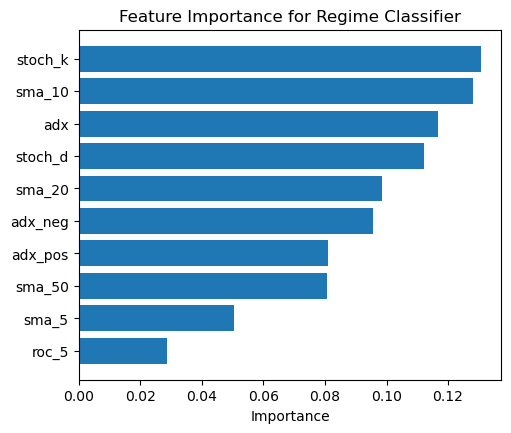

In [129]:
# Normalize to sum to 1
for col in feature_importance.columns:
    if col != 'Feature':
        feature_importance[col] = feature_importance[col] / feature_importance[col].sum()

# Sort by the regime classifier importance
feature_importance = feature_importance.sort_values('Regime Classifier', ascending=False).reset_index(drop=True)

# Display top features
print("Top Features by Importance:")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 10))

# Plot importance for regime classifier
plt.subplot(2, 2, 1)
top_features = feature_importance.head(10)  # Top 10 features
plt.barh(top_features['Feature'][::-1], top_features['Regime Classifier'][::-1])
plt.xlabel('Importance')
plt.title('Feature Importance for Regime Classifier')

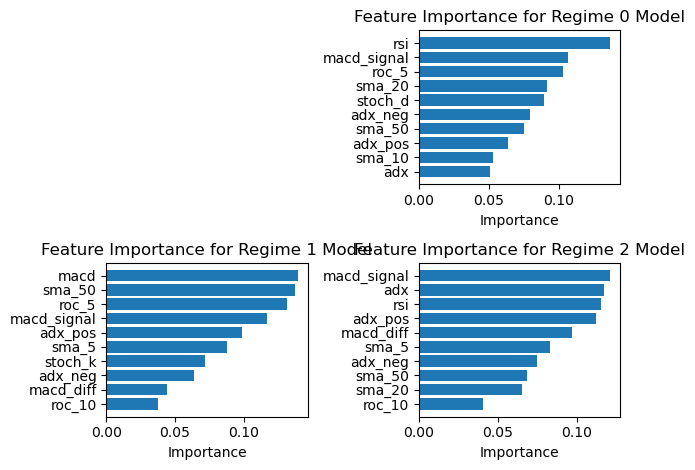

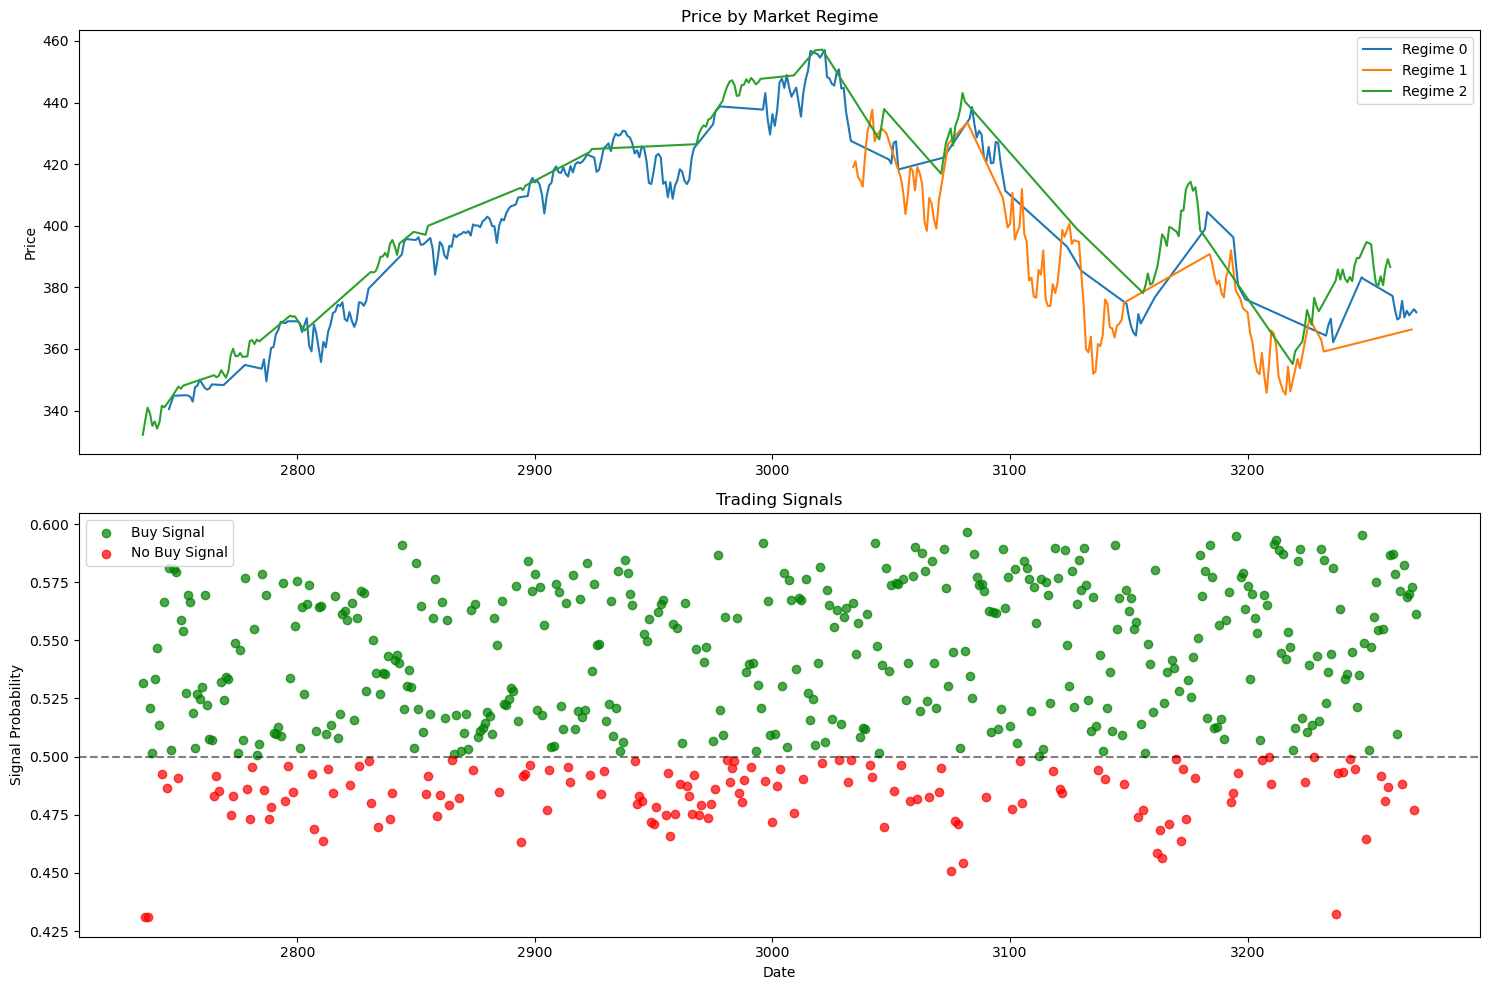

In [130]:
# Plot importance for each regime model
for i in range(num_regimes):
    plt.subplot(2, 2, i+2)
    # Sort by importance for this regime
    regime_importance = feature_importance.sort_values(f'Regime {i} Model', ascending=False).head(10)
    plt.barh(regime_importance['Feature'][::-1], regime_importance[f'Regime {i} Model'][::-1])
    plt.xlabel('Importance')
    plt.title(f'Feature Importance for Regime {i} Model')

plt.tight_layout()
plt.show()

# Visualize regime transitions over time with price overlay
plt.figure(figsize=(15, 10))

# Price with regimes highlighted
ax1 = plt.subplot(211)
for regime in sorted(eval_results['regime'].unique()):
    regime_data = eval_results[eval_results['regime'] == regime]
    ax1.plot(regime_data['Date'], regime_data['Close'], 
             label=f'Regime {regime}')

ax1.set_ylabel('Price')
ax1.set_title('Price by Market Regime')
ax1.legend()

# Trading signals
ax2 = plt.subplot(212, sharex=ax1)
buy_signals = eval_results[eval_results['predicted_signal'] == 1]
hold_signals = eval_results[eval_results['predicted_signal'] == 0]

ax2.scatter(buy_signals['Date'], buy_signals['signal_probability'], 
           color='green', label='Buy Signal', alpha=0.7)
ax2.scatter(hold_signals['Date'], hold_signals['signal_probability'], 
           color='red', label='No Buy Signal', alpha=0.7)

ax2.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
ax2.set_ylabel('Signal Probability')
ax2.set_xlabel('Date')
ax2.set_title('Trading Signals')
ax2.legend()

plt.tight_layout()
plt.show()

In [134]:
# Summary of model performance
summary_data = {
    'Metric': [
        'Overall Signal Accuracy',
        'Regime Classification Accuracy',
        'Strategy Sharpe Ratio',
        'Strategy vs Buy & Hold',
        'Win Rate',
        'Best Performing Regime',
        'Worst Performing Regime'
    ],
    'Value': [
        f"{val_acc:.2%}",
        f"{val_regime_acc:.2%}",
        performance_df.loc[1, 'Sharpe Ratio'],
        "Outperforms" if float(performance_df.loc[1, 'Total Return'].rstrip('%')) / 100 > float(performance_df.loc[0, 'Total Return'].rstrip('%')) / 100 else "Underperforms",
        f"Regime {plot_data['strategy_return'].idxmax()}",
        f"Regime {plot_data['strategy_return'].idxmin()}"
    ]
}

AttributeError: 'float' object has no attribute 'rstrip'

In [177]:
summary_df = pd.DataFrame(summary_data)
print("\nModel Performance Summary:")
print(summary_df)

# Display summary as a table
plt.figure(figsize=(10, 6))
plt.axis('tight')
plt.axis('off')
table = plt.table(cellText=summary_df.values,
                 colLabels=summary_df.columns,
                 cellLoc='center',
                 loc='center',
                 colWidths=[0.4, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)
plt.title('Model Performance Summary', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

NameError: name 'summary_data' is not defined